# Simulating Data and Hacker Statistics

In this notebook, we'll learn how to simulate data and delve into how doing so can help us think both probabilistically and statistically. We'll simulate data using `numpy` but all the techniques are library-agnostic.

As we have seen, science is deeply interested in questions of the form:

- Given data collected in the world, what can we say about the data-generating process(es)? That is, what is $P(M|D)$, the probability of any model $M$, given the observed/collected data $D$?

On the other hand, statistics and probability are better at answering questions such as:

- Given the model $M$, what is the probability $P(D|M)$ of observing the data $D$?

Recall that it will be Bayesian inference that eventually allows us to move between $P(D|M)$ and $P(M|D)$.

Before jumping into this, it will be instructive to delve into probability distributions and the data-generating processes that correspond to them.

To this end, we'll begin by exploring how simulation and hacker statistics can help us answer questions of the second kind above: knowing the model, what is the probability of seeing certain data? This will then allow to think about how to answer questions of the first kind, those of deep interest to science.

## Simulating our first probabilities: click-through rates and (biased) coin flips

For a first example, let's consider a common concept in data science, that of website click-through rates.

**The Question:** Let's say that a website has a click-through rate (CTR) of 50%, that is, we expect 50% of people from the general population to click through. If we drew 1,000 people at random from the general population, can we calculate the likelihood of $x$ number of people clicking through?

We can simulate this using `numpy`'s random number generator. To do so, first note we can use `np.random.default_rng.random()` to randomly select floats between 0 and 1 (known as the _uniform distribution_). Below, we do so and plot a histogram:

In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

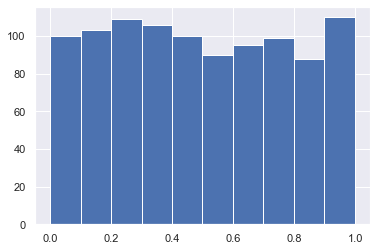

In [2]:
# Draw 1,000 samples from uniform & plot results
rng = np.random.default_rng()
x = rng.random(1000)
plt.hist(x);

To then simulate the sampling from the population, we check whether each float was greater or less than 0.5. For each float, if it is less than or equal to 0.5, we say the person clicked. If it is greater than 0.5, we say that they didn't click. We also print out the computed number of clicks:

In [3]:
# Computed how many people click
clicks = x <= 0.5
n_clicks = sum(clicks)
f"Number of clicks = {n_clicks}"

'Number of clicks = 518'

This is the total number of clicks but we're often more interested in the proportion of clicks, as it doesn't depend on the sample size. So let's compute that now:

In [4]:
# Computed proportion of people who clicked
f"Proportion who clicked = {n_clicks/len(clicks)}"

'Proportion who clicked = 0.518'

Now we've just computed the number and proportion of people who clicked, given a particular CTR. Essentially, we've performed a mini (computational) experiment! However, as we've mentioned, scientific questions are often the reverse of this. In this case, the question would be: given the data above and the measured proportion of people who clicked, what can you say about the click-through rate?

This question contains several sub-questions, such  as

* What would your "best" estimate of the CTR be? and
* How confident would you be of your estimate?

Perhaps your answer to the first question is "the proportion of people who clicked" and to the second "I'm not certain but I'd be more confident the more samples there were." If so, you're on the right track and we'll see why soon. Part of the power of Bayes, as we'll see, is that it allows us to recover not merely the best estimate and confidence intervals around it, but also the entire distribution of possible values and their likelihoods.

### Different click-through rates

One cool aspect of simulation techniques is that we can plug in different values and see the differences in results immediately. Let's see this in action by tweaking the above code to perform the same calculation for a CTR of 0.7. Once again, we'll compute the number of people who click, along with the proportion:

In [5]:
x = rng.random(1000)
clicks = x <= 0.7
n_clicks = sum(clicks)
print(f"Number of clicks = {n_clicks}")
print(f"Proportion who clicked = {n_clicks/len(clicks)}")

Number of clicks = 695
Proportion who clicked = 0.695


This model, in which the outcome is binary (that is, there are two options) and each outcome occurs with a certain probability, is known as the  _biased coin flip_ and is used to model lots of real-world phenomena, such as click-through or not, affected by disease or not, and bought a product or not, among many others. It's known as the _biased coin flip_ because it can be used to model the result of flipping a coin (heads or tails) when the probability of heads is not necessarily 0.5 (hence the "biased").

### Pseudo-random number generators and setting the seed

Reproducibility is fundamental to the scientific. Now what does reproducibility mean in the context of simulation and hacker statistics? Firstly, it would require that, were we to send you our code, that you could run it and get the same results. It also means that were we to run the same code twice, we'd get the same results. Let's run the most recent cell and see if we do:

In [6]:
x = rng.random(1000)
clicks = x <= 0.7
n_clicks = sum(clicks)
print(f"Number of clicks = {n_clicks}")
print(f"Proportion who clicked = {n_clicks/len(clicks)}")

Number of clicks = 724
Proportion who clicked = 0.724


We do not! This is unacceptable for science. So how do we ensure that we're able to reproduce our results?

To answer this question, let's spend a minute understanding a bit more about how, `numpy`, Python, and our computer generate random numbers. In truth, they don't quite. Rather, they generate pseudorandom numbers using what's known as a PRNG (pseudorandom number generator). These numbers are actually determined deterministically _but_ they have many statistical properties of randomly generated numbers that are suitable for our purposes. In fact, the sequence of numbers generated by any PRNG is uniquely determined by an initial value that we can set, known as the _seed_, for obvious reasons.

All this is to say that, once we set the seed with `numpy`, our results will then be reproducible! So let's now see this in action by setting the seed, performing the same CTR experiment as above, then setting the seed to the same value and re-performing the experiment:

In [7]:
# Set seed
rng = np.random.default_rng(42)
x = rng.random(1000)
clicks = x <= 0.7
n_clicks = sum(clicks)
print(f"Number of clicks = {n_clicks}")
print(f"Proportion who clicked = {n_clicks/len(clicks)}")

Number of clicks = 696
Proportion who clicked = 0.696


That's once. Let's try it again and see if we get the same result. 🤞

In [8]:
# Set seed
rng = np.random.default_rng(42)
x = rng.random(1000)
clicks = x <= 0.7
n_clicks = sum(clicks)
print(f"Number of clicks = {n_clicks}")
print(f"Proportion who clicked = {n_clicks/len(clicks)}")

Number of clicks = 696
Proportion who clicked = 0.696


And we do! Now all of our results are reproducible, as are yours.

## In which we introduce the binomial distribution to simulate coin flips

In the above, we have used the uniform distribution to sample from a series of biased coin flips. We now want to introduce you to another distribution that you can also use to do the same and with greater flexibility: the **binomial distribution**.

The **binomial distribution** with parameters $n$ and $p$ is defined as the probability distribution of

> the number of heads seen when flipping a coin $n$ times when  with $p(heads)=p$.

**Note** that this distribution essentially tells the **story** of a general model in the following sense: if we believe that they underlying process generating the observed data has a binary outcome (affected by disease or not, head or not, 0 or 1, clicked through or not), and that one the of the two outcomes occurs with probability $p$, then the probability of seeing a particular outcome is given by the **binomial distribution** with parameters $n$ and $p$.

Any process that matches the coin flip story is a Binomial process. Note that you'll see such coin flips also referred to as Bernoulli trials in the literature. So we can also formulate the story of the Binomial distribution as

> the number $r$ of successes in $n$ Bernoulli trials with probability $p$ of success, is Binomially distributed. 

We'll now use the binomial distribution to answer the same question as above: If P(heads) = 0.7 and we flip the coin ten times, how many heads will come up? We'll also set the seed to ensure reproducible results.

In [9]:
# Set seed
rng = np.random.default_rng(42)

# Simulate one run of flipping the biased coin 10 times
rng.binomial(10, 0.7)

6

### Simulating many times to get the binomial distribution

In the above, we have simulated the scenario once. But this only tells us one potential outcome. To see how likely it is to get $n$ heads, for example, we need to simulate it a lot of times and check what proportion of simulations ended up with $n$ heads. To do this, we can handily use the 3rd positional argument of `np.random.binomial()` as follows:

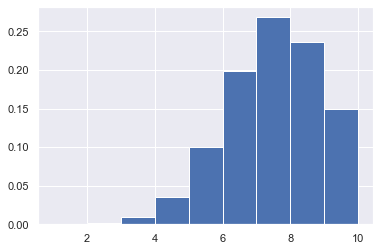

In [10]:
# Simulate 10,000 run of flipping the biased coin 10 times
x = rng.binomial(10, 0.7, 10000)

# Plot normalized histogram of results
plt.hist(x, density=True, bins=9);

It is always important to take a look at your plots and extract information from them. So what can we see here? We can see that the number of heads ranges from 2 to 10 and that just over 25% of the runs have 7 heads, which accords with our intuition, knowing that P(heads) = 0.7.

### Answering more questions about the model

Using such techniques, we can ask (and answer!) very many more questions that may be of interest to us. For example, we may not want the entire distribution, as above. We may want to know the probability of getting a certain number of heads. For example, we can ask the question: If I flip a biased coin ($P(H)=0.3$) 20 times, what is the probability of 5 or more heads? And we can answer it by simulating the experiment, as follows:

In [11]:
sum(rng.binomial(20, 0.3, 10000) >= 5)/10000

0.7628

Perhaps you discover that your coin is actually fair (P(heads) = 0.5) and your question becomes:
If I flip a fair coin 20 times, what is the probability of 5 or more heads? You can then simulate the answer as follows:

In [12]:
sum(rng.binomial(20,0.5,10000) >= 5)/10000

0.9937

Let's say that you wanted the entire distribution of possible number of heads when flipping a fair coin 10 times. You can simulate the experiment and plot the histogram in this manner:

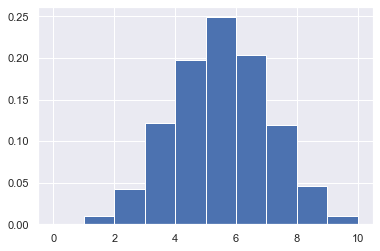

In [13]:
# Plot histogram 
x = rng.binomial(10, 0.5, 10000)
plt.hist(x, density=True, bins=10);

**Note:** you may have noticed that the _binomial distribution_ can take on only  a finite number of values, whereas the _uniform distribution_ above can take on any number between $0$ and $1$. These are different enough cases to warrant special mention of this & two different names: the former is called a _probability mass function_ (PMF) and the latter a _probability distribution function_ (PDF). We will discuss more about this point later but wanted to draw your attention to it.

Although this histogram is instructive, there are certain questions which we cannot trivially answer by reading off the histogram. For example, if you wanted to know the probability of seeing 4 or more heads, you'd have to squint, approximate the height of several boxes, and add up those values. In the next chapter, we'll introduce you to a figure known as the empirical cumulative distribution function (ECDF), which makes it far easier to answer questions such as this, and also has many other benefits.

## Practical example: Test for infectious disease

Suppose that a test for an infectious disease X has 99% sensitivity (true positive rate) and 99% specificity (true negative rate), that is, a 1% false positive rate and 1% false negative rate. Suppose that 0.5% (5 in 1,000) of people have X. What is the probability that a randomly selected individual with a positive test has X?

We'll now harness our new computational powers and the intuition of simulation to solve this infectious disease testing example. Before doing so, however, what do you think the answer to the question "What is the probability that a randomly selected individual with a positive test has X?" would be?

In [14]:
# Take 10,000 subjects
n = 100000
# Sample for number with X and without X
X = rng.binomial(n, 0.005, 1) 
not_X = n - X

In [15]:
# How many of those with X tested +ve ?
X_pos = rng.binomial(X, 0.99)
# How many of those without X tested +ve ?
non_pos = rng.binomial(not_X, 0.01)

In [16]:
# how many of those +ve tests were for people with X?
X_pos/(X_pos+non_pos)

array([0.32035737])

If you were surprised at the answer, that's not too surprising: you've just experienced the [base rate fallacy](https://en.wikipedia.org/wiki/Base_rate_fallacy). The base rate of 99% true positive may lead one to think that most positive tests will be of people who have X, however the vast majority of the overall population don't have X, which means that there will be more that test positive incorrectly than one would otherwise expect. You may also have noticed that mistaking $P(+ve|disease)$ for $P(disease|+ve)$ is an example of Bernoulli's fallacy!

## Wrapping up

In this notebook, we've introduced you to the foundations of random sampling and hacker statistics using `numpy`'s random number generator. We've simulated data-generating processes using both the uniform distribution and the binomial distribution. We've introduced the story corresponding to the binomial distribution and many real-world phenomena that it is used to model.

In the next notebook, we'll use Monte Carlo simulation to see how wildly applicable these techniques and distributions are to many concepts and problems in statistics and basic science, from diffusion and drift, to approximations of the Normal distribution, to the cognitive bias considerations of the Law of Small Numbers and selection bias, not to mention approximating $\pi$.
